In [1]:
continuous_series_names = [
    'brownian_motion',
    'gym_halfcheetah',
    'gym_halfcheetah_expert',
]
markov_chain_names = ['markov_chain']

import numpy as np

### Set up directory
import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append("/home/abenechehab/llmICL/")

os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"

from tqdm import tqdm
import pickle
import torch
from llama import get_model_and_tokenizer
from ICL import MultiResolutionPDF, recursive_refiner, trim_kv_cache

# Check if directory exists, if not create it
save_path = Path(parent_dir) / 'processed_series_RL'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# Define the directory where the generated series are stored
generated_series_dir = Path(parent_dir) / 'generated_series_RL'

In [2]:
def calculate_Markov(full_series, llama_size = '13b'):
    '''
     This function calculates the multi-resolution probability density function (PDF) for a given series.

     Parameters:
     full_series (str): The series for which the PDF is to be calculated.
     llama_size (str, optional): The size of the llama model. Defaults to '13b'.

     Returns:

    '''
    model, tokenizer = get_model_and_tokenizer(llama_size)
    states = sorted(set(full_series))
    good_tokens = [tokenizer.convert_tokens_to_ids(state) for state in states]
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True        
    )
    torch.cuda.empty_cache()
    with torch.no_grad():
        out = model(batch['input_ids'].cpu())
    logit_mat = out['logits']
    logit_mat_good = logit_mat[:,:,good_tokens].cpu()

    return logit_mat_good

def calculate_multiPDF(full_series, prec, mode = 'neighbor', refine_depth = 1, llama_size = '13b', use_instruct = False):
    '''
     This function calculates the multi-resolution probability density function (PDF) for a given series.

     Parameters:
     full_series (str): The series for which the PDF is to be calculated.
     prec (int): The precision of the PDF.
     mode (str, optional): The mode of calculation. Defaults to 'neighbor'.
     refine_depth (int, optional): The depth of refinement for the PDF. Defaults to 1.
     llama_size (str, optional): The size of the llama model. Defaults to '13b'.

     Returns:
     list: A list of PDFs for the series.
    '''
    if llama_size != '13b':
        assert False, "Llama size must be '13b'"
    good_tokens_str = list("0123456789")
    print(f"good_tokens_str: {good_tokens_str}")
    good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
    print(f"good_tokens: {good_tokens}")
    assert refine_depth < prec, "Refine depth must be less than precision"
    refine_depth = refine_depth - prec
    curr = -prec
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True        
    )
    print(f"batch['input_ids']: shape | {batch['input_ids'].shape}, sample | {batch['input_ids'][0,:10]}")
    torch.cuda.empty_cache()
    with torch.no_grad():
        out = model(batch['input_ids'].cuda(), use_cache=True)
    print(f"out: {list(out.keys())}")
    logit_mat = out['logits']
    print(f"logit_mat: shape | {logit_mat.shape}, sample | {logit_mat[:10]}")
    kv_cache_main = out['past_key_values']
    logit_mat_good = logit_mat[:,:,good_tokens].clone()
    print(f"logit_mat_good: shape | {logit_mat_good.shape}, sample | {logit_mat_good[:10]}")
    probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:], dim=-1)
    
    PDF_list = []
    comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])

    start_loop_from = 1 if use_instruct else 0
    for i in tqdm(range(start_loop_from, len(comma_locations))):
        PDF = MultiResolutionPDF()
        # slice out the number before ith comma
        if i == 0:
            start_idx = 0
        else:
            start_idx = comma_locations[i-1]+1
        end_idx = comma_locations[i]
        num_slice = full_series[start_idx:end_idx]
        prob_slice = probs[0,start_idx:end_idx].cpu().numpy()
        ### Load hierarchical PDF 
        # print(f"prob_slice: {prob_slice.shape}, type: {type(prob_slice)}")
        # print(f"num_slice: {num_slice}, type: {type(num_slice)}")
        PDF.load_from_num_prob(num_slice, prob_slice)
        
        ### Refine hierarchical PDF
        seq = full_series[:end_idx]
        # cache and full_series are shifted from beginning, not end
        end_idx_neg = end_idx - len(full_series)
        ### kv cache contains seq[0:-1]
        kv_cache = trim_kv_cache(kv_cache_main, end_idx_neg-1)
        recursive_refiner(PDF, seq, curr = curr, main = True, refine_depth = refine_depth, mode = mode, 
                        kv_cache = kv_cache, model = model, tokenizer = tokenizer, good_tokens=good_tokens)

        PDF_list += [PDF]

        if i==10:
            print(f"start_idx: {start_idx}")
            print(f"end_idx: {end_idx}")
            print(f"num_slice: {num_slice}")
            print(f"prob_slice: {prob_slice}")
            print(f"PDF_list: shape | {len(PDF_list)}, sample | {PDF_list[:10]}")
        
    # release memory
    del logit_mat, kv_cache_main
    return PDF_list

In [3]:
model, tokenizer = get_model_and_tokenizer('7b')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Initialize dictionaries to store the data for continuous series and Markov chains
continuous_series_task = {}
markov_chain_task = {}

# Loop through each file in the directory
for file in generated_series_dir.iterdir():
    # Check if a series is already processed
    # if not (save_path / file.name).exists():\
    # Extract the series name from the file name
    series_name = file.stem.rsplit('_', 1)[0]
    # If the series is a continuous series, load the data into the continuous_series_data dictionary
    if series_name in continuous_series_names:
        continuous_series_task[file.name] = pickle.load(file.open('rb'))
    # If the series is a Markov chain, load the data into the markov_chain_data dictionary
    elif series_name in markov_chain_names:
        markov_chain_task[file.name] = pickle.load(file.open('rb'))
    # If the series name is not recognized, raise an exception
    # else:
    #     raise Exception(f"Unrecognized series name: {series_name}")
        


In [5]:
print(continuous_series_task.keys())
print(markov_chain_task.keys())

dict_keys(['gym_halfcheetah_15.pkl', 'gym_halfcheetah_5.pkl', 'gym_halfcheetah_expert_7.pkl', 'gym_halfcheetah_expert_16.pkl', 'brownian_motion_4.pkl', 'brownian_motion_14.pkl', 'gym_halfcheetah_9.pkl', 'gym_halfcheetah_0.pkl', 'gym_halfcheetah_expert_1.pkl', 'brownian_motion_13.pkl', 'brownian_motion_17.pkl', 'gym_halfcheetah_expert_14.pkl', 'gym_halfcheetah_expert_8.pkl', 'gym_halfcheetah_1.pkl', 'brownian_motion_7.pkl', 'gym_halfcheetah_expert_6.pkl', 'brownian_motion_11.pkl', 'gym_halfcheetah_expert_12.pkl', 'gym_halfcheetah_10.pkl', 'gym_halfcheetah_3.pkl', 'gym_halfcheetah_13.pkl', 'brownian_motion_10.pkl', 'brownian_motion_6.pkl', 'brownian_motion_21.pkl', 'brownian_motion_2.pkl', 'brownian_motion_5.pkl', 'gym_halfcheetah_8.pkl', 'brownian_motion_9.pkl', 'gym_halfcheetah_expert_11.pkl', 'gym_halfcheetah_6.pkl', 'gym_halfcheetah_expert_9.pkl', 'brownian_motion_16.pkl', 'gym_halfcheetah_12.pkl', 'gym_halfcheetah_expert_10.pkl', 'brownian_motion_15.pkl', 'brownian_motion_3.pkl', 'g

### Analyze Multi Digit series

In [6]:
pre_prompt = "predict the next element of this series of observations,"
for series_name, series_dict in sorted(continuous_series_task.items()):
    print("Processing ", series_name)
    if series_name in ['brownian_motion_0.pkl']:
        full_series = series_dict['full_series']
        prec = series_dict['prec']
        refine_depth = series_dict['refine_depth']
        llama_size = series_dict['llama_size']
        mode = series_dict['mode']
        PDF_list = calculate_multiPDF(pre_prompt+full_series, prec, mode = mode, refine_depth = refine_depth, llama_size = llama_size, use_instruct=True)
        series_dict['PDF_list'] = PDF_list
        save_name = os.path.join(save_path, series_name)
        with open(save_name, 'wb') as f:
            pickle.dump(series_dict, f)

Processing  brownian_motion_0.pkl
good_tokens_str: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
good_tokens: [29900, 29896, 29906, 29941, 29946, 29945, 29953, 29955, 29947, 29929]
batch['input_ids']: shape | torch.Size([1, 4011]), sample | tensor([    1,  8500,   278,  2446,  1543,   310,   445,  3652,   310, 13917])
out: ['logits', 'past_key_values']
logit_mat: shape | torch.Size([1, 4011, 32000]), sample | tensor([[[ 0.1040, -0.2216,  0.3127,  ...,  1.3271,  1.8799,  0.6436],
         [-8.8594, -7.1992, -1.0732,  ..., -5.7734, -9.5469, -6.6016],
         [-4.5078, -1.9961,  1.8467,  ..., -0.0553, -2.0625, -2.6582],
         ...,
         [-5.2422, -4.8398,  5.3945,  ..., -3.4863, -4.6055, -2.6797],
         [-1.6309,  0.4780, 10.1172,  ...,  0.5786, -1.4502,  0.0798],
         [-4.5273, -4.5742,  6.6992,  ..., -2.5215, -1.7510, -1.7568]]],
       device='cuda:0')
logit_mat_good: shape | torch.Size([1, 4011, 10]), sample | tensor([[[ 0.3350, -0.0311,  0.2466,  ...,  0.2357,  0.3

  1%|█▏                                                                                                       | 11/1000 [00:01<02:14,  7.34it/s]

start_idx: 92
end_idx: 95
num_slice: 780
prob_slice: [[2.55882367e-02 4.89387847e-02 4.08898853e-02 4.38684449e-02
  9.35978740e-02 9.58174914e-02 4.78051230e-02 4.75329250e-01
  6.48333579e-02 6.33314997e-02]
 [2.14069005e-05 8.01600982e-05 6.05080131e-05 3.39419203e-05
  1.14824041e-04 2.39313827e-04 8.82239314e-04 9.98204350e-01
  2.97830848e-04 6.54247633e-05]
 [1.68434897e-04 1.80704257e-04 1.30430318e-03 1.36977490e-02
  2.58457571e-01 2.79459268e-01 2.54450560e-01 1.80432469e-01
  1.05848005e-02 1.26417412e-03]]
PDF_list: shape | 10, sample | [<ICL.MultiResolutionPDF object at 0x7f28238a8490>, <ICL.MultiResolutionPDF object at 0x7f28238a83d0>, <ICL.MultiResolutionPDF object at 0x7f28238b6ee0>, <ICL.MultiResolutionPDF object at 0x7f28238b9f40>, <ICL.MultiResolutionPDF object at 0x7f28238c4fd0>, <ICL.MultiResolutionPDF object at 0x7f28238b2f40>, <ICL.MultiResolutionPDF object at 0x7f28238c1f10>, <ICL.MultiResolutionPDF object at 0x7f2854770ee0>, <ICL.MultiResolutionPDF object at 0

 63%|█████████████████████████████████████████████████████████████████▊                                      | 633/1000 [01:44<01:00,  6.05it/s]


KeyboardInterrupt: 

In [ ]:
PDF_list[5].__dir__()

In [ ]:
PDF_list[5].sigma

### Analyze Markov Series

In [12]:
for series_name, series_dict in sorted(markov_chain_task.items()):
    print("Processing ", series_name)
    full_series = series_dict['full_series']
    llama_size = series_dict['llama_size']
    logit_mat_good = calculate_Markov(full_series, llama_size = llama_size)    
    series_dict['logit_mat_good'] = logit_mat_good
    save_name = os.path.join(save_path, series_name)
    with open(save_name, 'wb') as f:
        pickle.dump(series_dict, f)
    break

In [42]:
import matplotlib.pyplot as plt

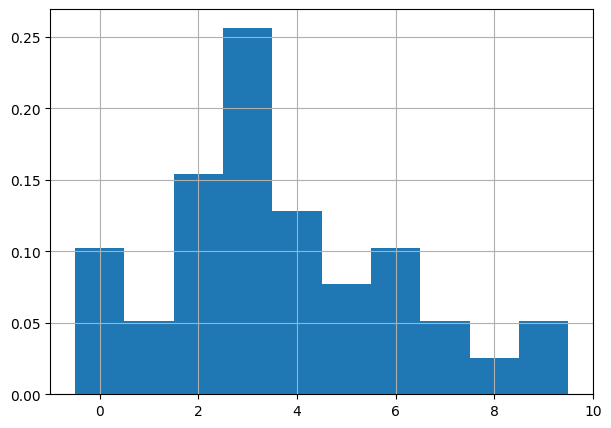

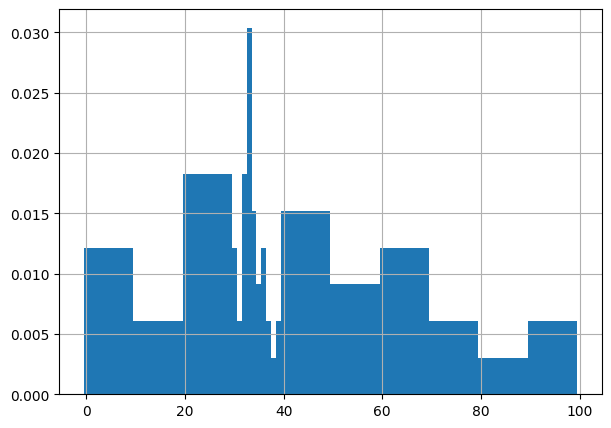

In [87]:
bins = [4,2,6,10,5,3,4,2,1,2]
plt.figure(figsize=(7,5))
plt.bar(x=np.arange(len(bins)), height=np.array(bins)/sum(bins), width=1.0)
plt.grid(True)
two_bins = []
for i, b in enumerate(bins):
    if i in [3]:
        two_bins += bins
    else:
        two_bins += [b]*10
plt.figure(figsize=(7,5))
plt.bar(x=np.arange(len(two_bins)), height=np.array(two_bins)/sum(two_bins), width=1.0)
plt.grid(True)
plt.show()